In [189]:
import pickle as pckl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt

# from sklearn.pipeline import Pipeline

from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

In [2]:
# adjustable parameters
num_features = 1000
num_topics = 10
num_top_words = 10
num_top_reviews = 3



In [3]:
df = pckl.load(open('ARK_14_pos_sents.pckl','rb'))
#df = df_full[(df_full['1day_deriv'] < 0) & (df_full['1day_forcast'] < -0.08)]
reviews = df['review']

In [89]:
df_14day = pckl.load(open('ARK_sorted_data_0122.pckl','rb'))

In [90]:
df_14day.head()

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [337]:
ws_tokenizer = WhitespaceTokenizer()
lancaster = LancasterStemmer()
porter = PorterStemmer()
snowball = SnowballStemmer('english')

try:
    stopwords = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))

In [338]:
def cleanText(text):
    
    # import a dictionary of English contractions from another file
    from contractions import contractions_dict
    contraction_dict = contractions_dict

    # replace the contractions with their expanded form
    for contraction, expansion in contraction_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    symbols = ['\'', '\"', '.', ',', '[', ']', '(', ')', '?', '!', '@', '$', '#', '&', '%']
    
    text = text.strip().replace('\n', ' ').replace('\r', ' ').replace('-',' ')
    
    
    
    for symbol in symbols:
        text = text.replace(symbol, '')

    # lowercase
    text = text.lower()

    return text

In [5]:
def gen_tokens(review, *args):

    ws_tokenized = ws_tokenizer.tokenize(review)
    #print(type(ws_tokenized),ws_tokenized[0])

    cleaned_tokens = []

    for token in ws_tokenized:
        if token not in stopwords:
            cleaned_tokens.append(token.lower().strip())
            
    #print(type(cleaned_tokens),cleaned_tokens[0])
    
    clean_tokens =  ' '.join(cleaned_tokens)

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            #stemmed_tokens.append(lancaster.stem(token))
            stemmed_tokens.append(lancaster.stem(token.lower().strip()))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token.lower().strip()))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token.lower().strip()))

    stemmed_text = ' '.join(stemmed_tokens)

    return clean_tokens

In [339]:
def clean_and_tokenize(reviews):
    cleaned_reviews = []

    for review in reviews:
        review_tokens = []
        cleaned_text = cleanText(review)
        cleaned_reviews.append(gen_tokens(cleaned_text))
        
    return cleaned_reviews

In [652]:
#neg_forecasts = pckl.load(open('neg_forecasts_14day.pckl','rb'))

In [653]:
#full_df = pckl.load(open('ARK_14day_FULL2.pckl','rb'))

In [146]:
neg_indices = full_df.index[(full_df['pos_sent'] < full_df['pos_sent'].mean()) &
              (full_df['neg_sent'] > full_df['neg_sent'].mean()) &
              (full_df['1day_delta'] < -0.08)].tolist()

pos_indices = full_df.index[(full_df['pos_sent'] > full_df['pos_sent'].mean()) &
              (full_df['neg_sent'] < full_df['neg_sent'].mean()) &
              (full_df['1day_delta'] > 0.08)].tolist()

In [160]:
pos_tfidf = np.empty((0,num_features), int)

for i in pos_indices:
    pos_tfidf = np.append(pos_tfidf, transform_array[i])

In [333]:
#df = pckl.load(open('ARK_dec8_window.pckl','rb'))
#df = df_full[(df_full['1day_deriv'] < 0) & (df_full['1day_forcast'] < -0.08)]
reviews = df['review']

In [336]:
len(reviews)

351

In [340]:
cleaned = clean_and_tokenize(reviews)

In [341]:
df['cleaned_reviews'] = cleaned

In [342]:
stop_list = ['like', 'game', 'ark', 'played', 'play', 'love', 'good', 'pretty', 'game',
            'fun', 'great', 'lot', 'best', 'awesome', 'ok', 'better', 'probably', 'games',]

In [354]:
params = {'num_features': 1000,
          'num_topics': 10,
          'num_top_words': 5,
          'num_top_reviews': 2}

In [345]:
vectorizer = TfidfVectorizer(stop_words=stop_list, 
                             max_features=num_features,
                             ngram_range=(1,3), 
                             max_df=0.7, min_df=3,
                            norm = 'l2')

# use NMF model with the Frobenius norm
implement_nmf = NMF(n_components=num_topics,
                    random_state=1,
                    solver='mu',
                    beta_loss='frobenius')

In [346]:
transform = vectorizer.fit_transform(df['cleaned_reviews'])
transform_array = transform.toarray()

In [347]:
# Non-negative matrix factorization (NMF) implementation W*H = original matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

W = implement_nmf.fit_transform(transform_array)
H = implement_nmf.components_

#### Sentiment analysis with _vaderSentiment_ package

In [348]:
def display_topics(vectorizer, clf, W, df, num_top_words, num_top_reviews):
    ''' Print out topics discovered by a model '''
    
    # get list of feature names
    feature_names = vectorizer.get_feature_names()
    
    # get vader sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()    
    
    # list of topics and reviews to return
    topics, sentiments, reviews = [], [], []
    
    # loop over all the topics
    for topic_id, topic in enumerate(clf.components_):
        
        sentiment_sum = 0
        
        # grab the list of words describing the topic
        word_list = []
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            word_list.append(feature_names[i])
        
        # split words in case there are some bigrams and get unique set
        split_list = []
        for word in word_list:
            for split in word.split():
                split_list.append(split)
                
        topic_words = list(set(split_list))
        
        # append topic words as a single string
        topics.append(' '.join([word for word in topic_words]))
        
        # print topic number and topic words
        print('Topic #%02d: %s' % (topic_id+1, topics[-1]))

        # loop over reviews for each topic
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:num_top_reviews]
        
        for doc_index in top_doc_indices:
            
            # check that the review contains one of the topic words
            if any(word in df['cleaned_reviews'].iloc[doc_index].lower() for word in topic_words):
                
                # sentiment analysis
                vader = analyzer.polarity_scores(df['cleaned_reviews'].iloc[doc_index])
                
                # append current review to the list 
                reviews.append(df.iloc[doc_index].to_dict())
                reviews[-1]['topic']       = topic_id
                reviews[-1]['topic_words'] = ' '.join([word for word in topic_words])
                reviews[-1]['sentiment']   = vader['compound']
                
                sentiment_sum += vader['compound']
                
                #print('User %20s on %s with rating %s' % (df['reviewerName'].iloc[doc_index][:20], 
                                     #df['reviewTime'].iloc[doc_index], df['overall'].iloc[doc_index]))            
                #print("VADER: %f" % vader['compound'])
                #print(reviews[-1]['reviewText'])
            else:
                print("WARNING: TOPIC NOT IN DOCUMENT")
                            
            print()
        
        sentiments.append(sentiment_sum)
        
    return topics, sentiments, reviews

In [349]:
topics, sentiments, assc_reviews = display_topics(vectorizer, implement_nmf, W, df, num_top_words, num_top_reviews)

#(vectorizer, clf, W, df, n_top_words, n_top_documents)

Topic #01: get one dinos hours server


Topic #02: 10 dodos would


Topic #03: made ever created far alpha


Topic #04: graphics pc low use fps


Topic #05: time survival perfect amazing evolved


Topic #06: said shit h1z1 minecraft dinosaurs


Topic #07: super worth purchase price buying


Topic #08: computer recomend run dont


Topic #09: time consuming playing stop awsome


Topic #10: work doesnt friends really dont




1

In [322]:
topics

,positive,negative,recent
0,wish solo friends playing,access dlc early paid,get time people server well
1,gameplay nice graphic guess really,even time devs get hours,run optimization pc shit fps
2,ive survival one ever,ea paid dlc finished,get sucks anyone please help
3,time playing get really hours,access early still,fix though help cant lag
4,amazing friends graphics maps,killed would 10,paid dlc instead fuck
5,ever survival still try one,bad fps really even,terrible would frame 10 lose
6,would 10,fuck fucking shit buy devs,join servers cool make cant
7,cool animals new dinos bugs,flyer patch nerf ruined flyers,much one computer optimized enough
8,going survival playing still enjoy,60 30 price 20 worth,graphics playing boring bad minutes
9,dinosaurs rust taming big dinosaur,fps join cant sucks server,work tame kill destroy dinos


In [29]:
#pckl.dump(topics, open('ARK_dec8_negtopics_0129.pckl','wb'))

In [482]:
#pckl.dump(topics,open('ARK_20neg_recent_topics.pckl','wb'))

In [102]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import DateFormatter
from sklearn import preprocessing
from math import log

In [182]:
begin = 41000
end = 53000#103106

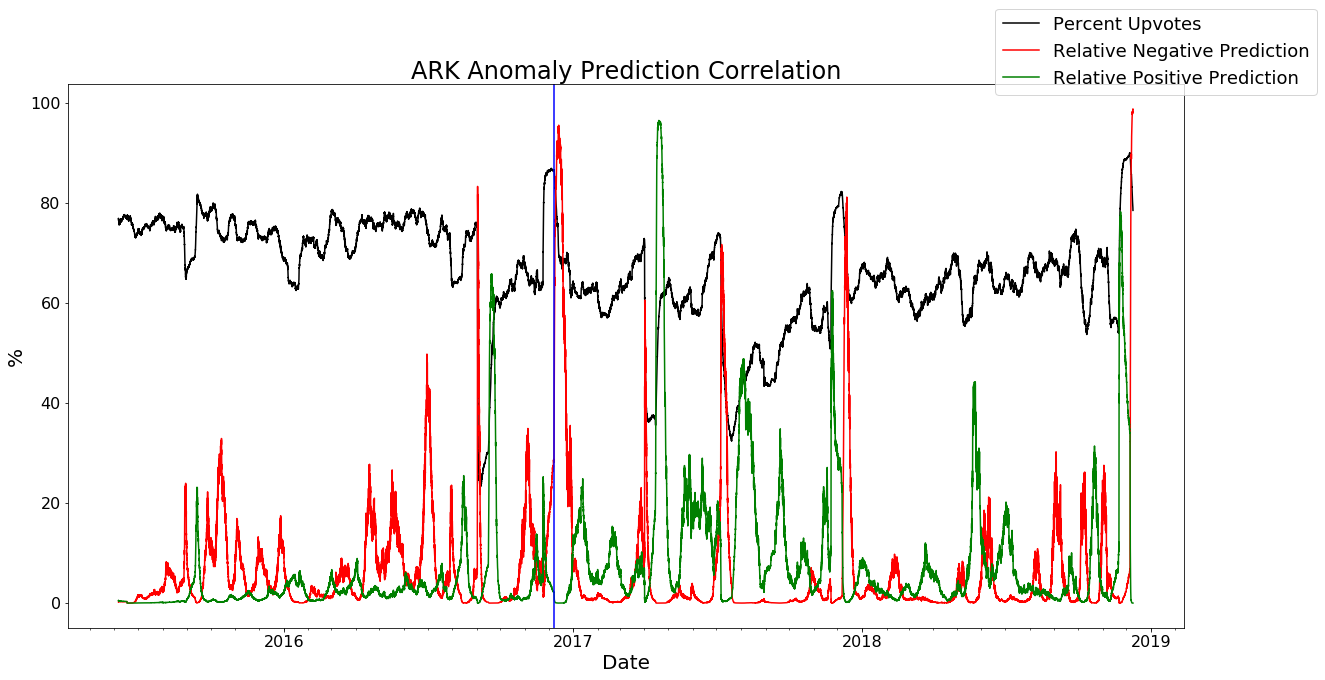

In [202]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

date = df['time_of_review'].iloc[2000:-2000]

fig, ax = plt.subplots(figsize=(20,10))

percent_window = df['percent_window'].iloc[2000:-2000]

ax.plot(date, 100*percent_window.values, 'k', date, 100*pd.Series(a).values, 'r',date, 100*pd.Series(b).values, 'g')
#ax.plot(date, prediction_scale, 'k', date, 100*percent_window.values)
#plt.plot(date[52700], 100*percent_window[52700], 'rX', ms = 20) #, date[52700],50*pd.Series(a)[52700], 'rX', ms = 20)
plt.axvline(dt.datetime(2016, 12, 8), color='b')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

fig.legend(['Percent Upvotes', 'Relative Negative Prediction' , 'Relative Positive Prediction'], loc='upper right', fontsize = 18)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.xlabel('Date', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.title('ARK Anomaly Prediction Correlation', fontsize=24)

plt.show()

In [200]:
#fig.savefig('ARK_dec8_zoom.png')

In [216]:
#c = ['r' if (df_model['neg_predict'] > 0.1)  elif 'g' else 'g' for a in annotation]
c = []
for i in range(len(df_model)):
    if df_model['neg_predict'].iloc[i] > 0.06:
        c.append('r')
    elif df_model['pos_predict'].iloc[i] > 0.15:
        c.append('g')
    else:
        c.append('k')

In [ ]:
import matplotlib.dates as mdates

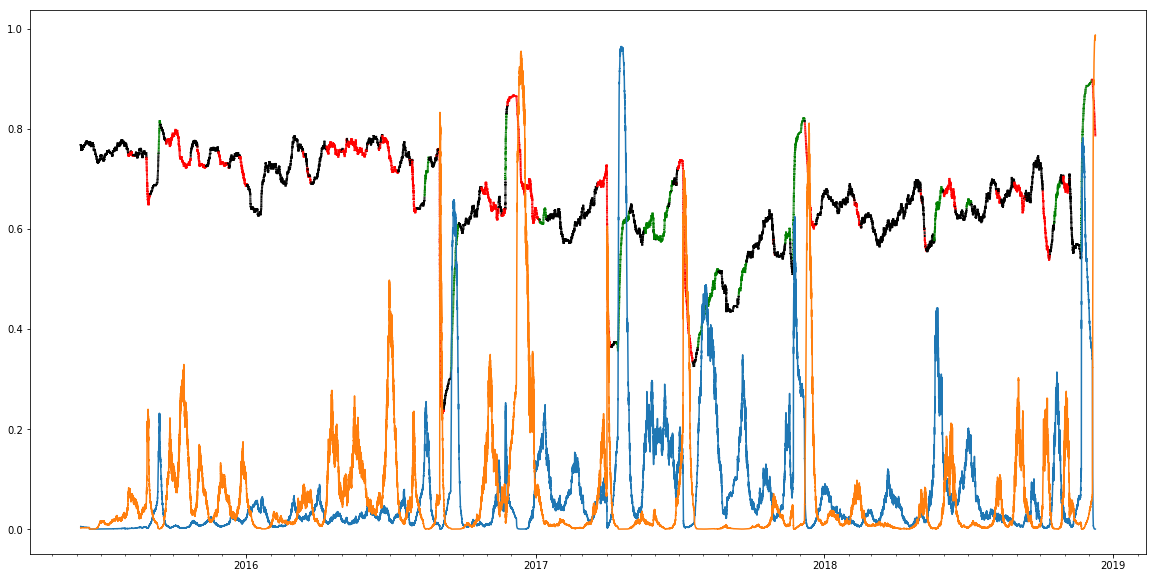

In [222]:
from matplotlib.collections import LineCollection





#x = df_model['time_of_review_unix']
y = df_model['percent_window']





dates = df_model['time_of_review']
pos = df_model['pos_predict']
neg = df_model['neg_predict']

s = pd.Series(df_model['time_of_review'], index=dates)

x = mdates.date2num(s.index.to_pydatetime())

years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')


lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidth=(2,))

# plot data
fig, ax = plt.subplots(figsize=(20,10))

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.add_collection(colored_lines)
ax.plot(date, 0.5*pos.values, 'g', date, 0.5*neg.values, 'r')
ax.autoscale_view()
plt.show()

In [237]:
y = 100*df_model['percent_window'].values

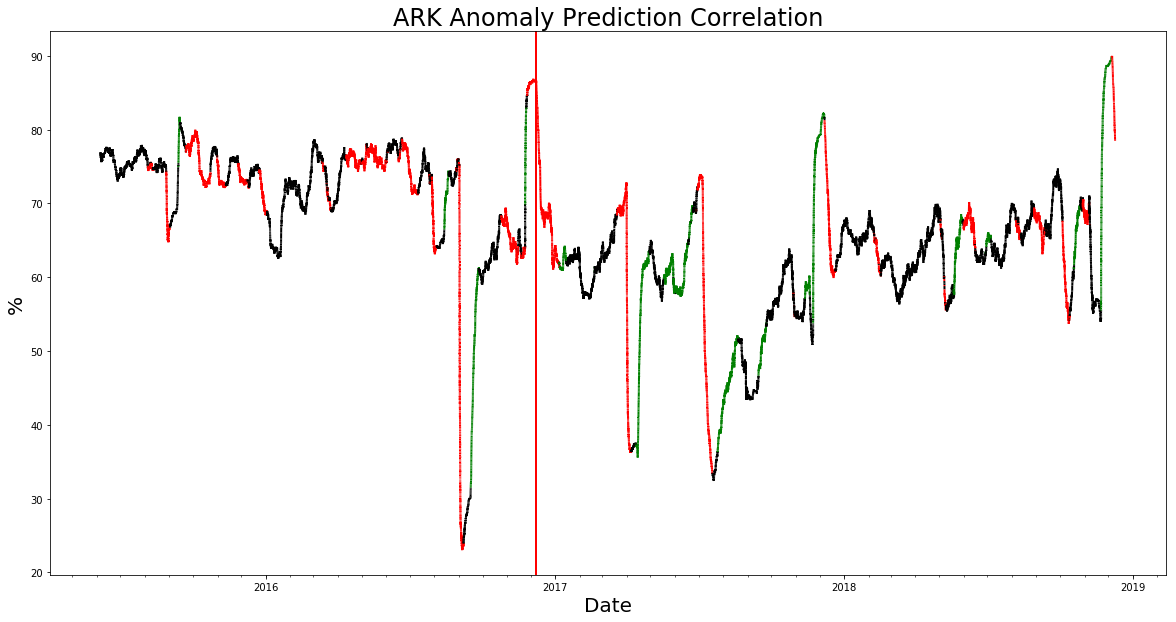

In [258]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')


lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidth=(2,))



# plot data
fig, ax = plt.subplots(figsize=(20,10))



ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

#ax.fill_between(x, 50*pos, 50*neg, where=neg >= pos, facecolor='red')
#ax.fill_between(x, 50*pos, 50*neg, where=neg <= pos, facecolor='green')

#plt.axhline(y=0.06*50, color='r')
#plt.axhline(y=0.15*50, color = 'g')
#plt.axvline(dt.datetime(2016, 12, 8), color='r', linewidth = 2)


plt.xlabel('Date', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.title('ARK Anomaly Prediction Correlation', fontsize=24)
#fig.legend(['Scaled Negative Prediction (50%)' , 'Scaled Positive Prediction (50%)'], loc='upper right', fontsize = 18)


ax.add_collection(colored_lines)
#ax.plot(date, 50*pos.values, 'g', date, 50*neg.values, 'r')
ax.autoscale_view()
plt.show()

In [256]:
fig.savefig('ARK_corr_upvote_only.png')

In [456]:
df_pos = df_model[df_model['pos_predict'] >= 0.15].copy()

In [457]:
pos_groups = df_pos.groupby(df_pos.index.to_series().diff().ne(1).cumsum()).groups

In [458]:
for i in range(len(pos_groups.keys())):
    if len(pos_groups[i+1]) < 200:
        pos_groups.pop(i+1, None)
    else:
        None

In [474]:
pos_groups

{7: Int64Index([46717, 46718, 46719, 46720, 46721, 46722, 46723, 46724, 46725,
             46726,
             ...
             47651, 47652, 47653, 47654, 47655, 47656, 47657, 47658, 47659,
             47660],
            dtype='int64', length=944),
 10: Int64Index([50337, 50338, 50339, 50340, 50341, 50342, 50343, 50344, 50345,
             50346,
             ...
             50983, 50984, 50985, 50986, 50987, 50988, 50989, 50990, 50991,
             50992],
            dtype='int64', length=656),
 35: Int64Index([54997, 54998, 54999, 55000, 55001, 55002, 55003, 55004, 55005,
             55006,
             ...
             55524, 55525, 55526, 55527, 55528, 55529, 55530, 55531, 55532,
             55533],
            dtype='int64', length=537),
 48: Int64Index([62865, 62866, 62867, 62868, 62869, 62870, 62871, 62872, 62873,
             62874,
             ...
             63759, 63760, 63761, 63762, 63763, 63764, 63765, 63766, 63767,
             63768],
            dtype='int64'

In [467]:
len(df_model)

103106

In [332]:
df = neg_groups_slice.copy()

In [464]:
params = {'num_features': 1000,
          'num_topics': 10,
          'num_top_words': 5,
          'num_top_reviews': 2}

In [372]:
import topics_pipeline
import importlib

importlib.reload(topics_pipeline)

<module 'topics_pipeline' from '/Users/tylerblair/Documents/insight/topics_pipeline.py'>

In [475]:
pos_topic_segments = topics_pipeline.topics(df_model, params, pos_groups)

In [380]:
#pckl.dump(neg_groups, open('ARK_neg_groups_0129.pckl','wb'))

In [510]:
pos_outputs = []
for key, i in zip(pos_groups.keys(), range(len(pos_groups))):
        pos_outputs.append(dict(group = pos_groups[key], full_topics = pos_topic_segments[i], topics = pos_clean_topics[i]))

In [400]:
#neg_topic_segments = pckl.load(open('ARK_neg_topic_segments_0129.pckl','rb'))

In [513]:
#pckl.dump(pos_outputs, open('pos_windows_interactive_ARK.pckl','wb'))

15

In [509]:
bbb = pos_clean_topics

In [477]:
pos_clean_topics = []
len(pos_topic_segments)

15

In [204]:
df_model = df.iloc[2000:-2000].copy()
df_model['neg_predict'] = a
df_model['pos_predict'] = b

In [206]:
#pckl.dump(df_model,open('ARK_model_df.pckl','wb'))

In [136]:
min(df['classification'].iloc[57000:59000])

-1.0

In [499]:
#fig.savefig('plots/ARK_dec816_example.png')

In [527]:
a

[0.0024600781671663303,
 0.0024375197308841886,
 0.002438272441358224,
 0.0024390245731179894,
 0.0024631434606561114,
 0.002440600648369287,
 0.002441351215443158,
 0.0024421012061413543,
 0.002442850621194865,
 0.0024205459892585224,
 0.0024212990636557374,
 0.0024220515642548153,
 0.0024228034917774836,
 0.002446663403118416,
 0.0024243780698638565,
 0.0024251284479275374,
 0.002425878255205155,
 0.0024497189609934164,
 0.0024505370191946325,
 0.0024745820482901734,
 0.002475320298412234,
 0.0024760579804972466,
 0.002453582221533254,
 0.0024543237315736858,
 0.0024783435864394365,
 0.002479079164427319,
 0.002479814177401329,
 0.002480624524806003,
 0.0024813585704367563,
 0.00248209205263003,
 0.0024828249720996384,
 0.00246038503870675,
 0.0024611217961529783,
 0.002485096677074968,
 0.002509278918270789,
 0.0024866338799921996,
 0.002487363754230506,
 0.0024880930695852376,
 0.002488821826762642,
 0.002466413380314589,
 0.002467145984206267,
 0.002467878031421722,
 0.00246860952

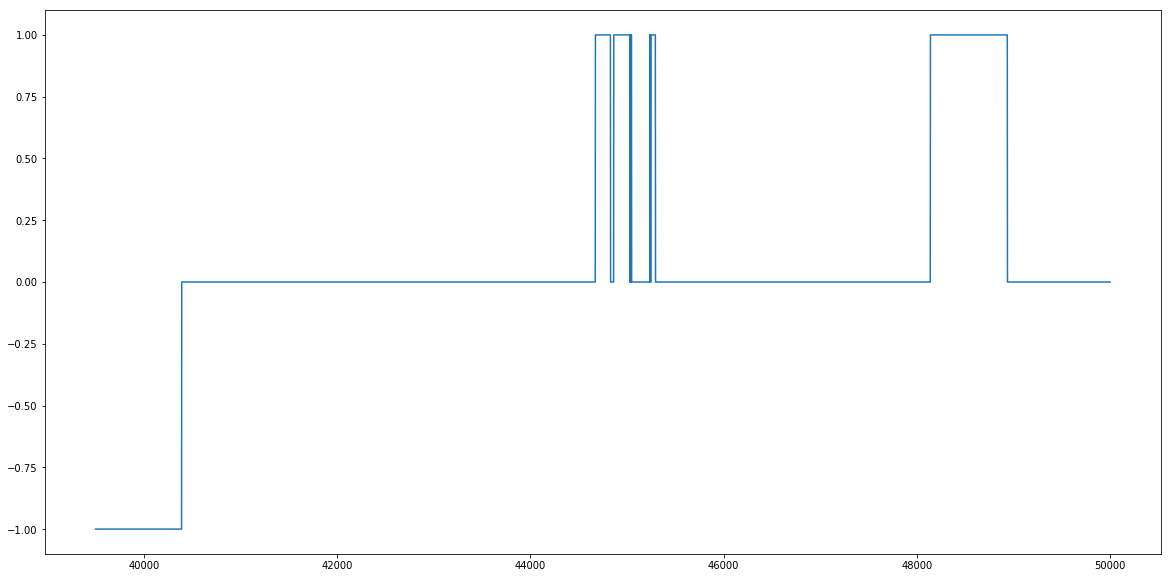

In [160]:
fig, ax = plt.subplots(figsize=(20,10))
x = pd.Series(range(len(predict_point_check)))

#ax.plot(x, a, x, df['percent_window'].iloc[2000:-2000])
ax.plot(x[39500:50000], df['classification'].iloc[39500:50000])#a[39500:50000])

In [158]:
min(df['classification'].iloc[39000:43000])

-1.0

In [208]:
#pckl.dump(full_df, open('ARK_14_full_class','wb'))

In [199]:
X = full_df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[2000:-2000]
Y = full_df['1day_forecast'].iloc[2000:-2000].copy()

dates = full_df['time_of_review']

In [203]:
Y_classes = []

for i in range(len(Y)):
    if Y.iloc[i] > Y.mean() + Y.std():
        Y_classes.append(1)
    elif Y.iloc[i] < Y.mean() - Y.std():
        Y_classes.append(-1)
    else:
        Y_classes.append(0)
        
Y_classification = pd.DataFrame({'class': Y_classes})

In [204]:
full_df['classification'] = Y_classification

In [529]:
#pckl.dump(full_df,open('ARK_14_full_class.pckl','wb'))

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(df.iloc[2000:-2000], test_size=0.2)

In [62]:
x_train = train[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']]
x_test = test[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']]

y_train = train['1day_forecast']
y_test = test['1day_forecast']

In [63]:
y_mean = df['1day_forecast'].iloc[2000:-2000].mean()
y_std = df['1day_forecast'].iloc[2000:-2000].std()
print(y_mean, y_std)

-0.002395604253335573 0.03637083387345207


Index(['time_of_review', 'review', 'upvoted', 'time_of_review_unix',
       'minutes_played', 'upvotes_window', 'total_window', 'percent_window',
       'neu_sent', 'neg_sent', 'pos_sent', 'comp_sent', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc',
       '1day_forecast', '1day_delta'],
      dtype='object')

In [64]:
y_train_classes = []


for i in range(len(y_train)):
    if y_train.iloc[i] > y_mean + y_std:
        y_train_classes.append(1)
    elif y_train.iloc[i] < y_mean - y_std:
        y_train_classes.append(-1)
    else:
        y_train_classes.append(0)
        
y_train_df = pd.DataFrame({'class': y_train_classes})

y_test_classes = []

for i in range(len(y_test)):
    if y_test.iloc[i] > y_mean + y_std:
        y_test_classes.append(1)
    elif y_test.iloc[i] < y_mean - y_std:
        y_test_classes.append(-1)
    else:
        y_test_classes.append(0)
        
y_test_df = pd.DataFrame({'class': y_test_classes})

In [72]:
weights = {-1: 3, 0: 1, 1: 3}

In [73]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1, solver='sag',
                         multi_class='multinomial',
                         max_iter = 10000, 
                         warm_start = False,
                         class_weight = weights).fit(x_train.values, y_train_df.values)
                                                                        
predictions = clf.predict(x_test.values)

predict_prob = clf.predict_proba(x_test.values) 

score = clf.score(x_test.values, y_test_df.values)


/Users/tylerblair/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
score

0.9078653864804578

In [37]:
df = pckl.load(open('ARK_14_full_class.pckl','rb'))

In [303]:
testy = full_df['classification'].iloc[39000:45000]

In [82]:
predict_point = df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[52700]#.iloc[39000:45000].values

predict_point_stat = clf.decision_function(predict_point.values.reshape(1,-1))

In [198]:
predict_point_stat

array([[ 1.516182  ,  1.44983844, -2.96602044]])

In [88]:
neg_predict = predict_point_stat[0][0]
neu_predict = predict_point_stat[0][1]
pos_predict = predict_point_stat[0][2]

neg_prob = 1/(1 + exp(-neg_predict))
neu_predict = 1/(1 + exp(-neu_predict))
pos_predict = 1/(1 + exp(-pos_predict))

true_neg = neg_prob/(neg_prob + neu_predict + pos_predict)
true_neg

0.488390616140471

In [86]:
from math import exp

In [107]:
predict_point_check = clf.predict_proba(df[['percent_window', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc']].iloc[2000:-2000])
print(predict_point_check)

[[2.16154283e-03 9.92522132e-01 5.31632483e-03]
 [2.14239882e-03 9.92479523e-01 5.37807815e-03]
 [2.14302078e-03 9.92488670e-01 5.36830885e-03]
 ...
 [9.85631314e-01 1.43337627e-02 3.49230533e-05]
 [9.87673346e-01 1.23004319e-02 2.62221577e-05]
 [9.86379451e-01 1.35949065e-02 2.56425022e-05]]


In [109]:
a = [x[0] for x in predict_point_check]
b = [x[2] for x in predict_point_check]
len(b)

103106

In [416]:
prediction = []

for i in range(len(predict_point_check)):
    
    negative = predict_point_check[i][0]
    neutral = predict_point_check[i][1]
    positive = predict_point_check[i][2]
    
    if (neutral >= positive) & (neutral >= negative):
        prediction.append(0)
    elif (negative > neutral) & (negative > positive):
        prediction.append(-1)
    else:
        prediction.append(1)

In [421]:
prediction_scale = 50 + 25*pd.Series(prediction).values

In [292]:
full_df['1day_forecast'].describe()['25%']

-0.006514546584899555

In [132]:
#num_top_words = 5

num_features = 1000
num_topics = 20
num_top_words = 5 # words per topic
num_top_reviews = 1

In [131]:
#pckl.dump(topics,open('ARK_total_neg_sents.pckl','wb'))

In [13]:
df = pckl.load(open('ARK_14_full_class.pckl','rb'))
df.columns

Index(['time_of_review', 'review', 'upvoted', 'time_of_review_unix',
       'minutes_played', 'upvotes_window', 'total_window', 'percent_window',
       'neu_sent', 'neg_sent', 'pos_sent', 'comp_sent', 'neu_window',
       'neg_window', 'pos_window', 'comp_window', 'percent_window_roc',
       'neu_window_roc', 'neg_window_roc', 'pos_window_roc', 'comp_window_roc',
       '1day_forecast', '1day_delta', 'classification'],
      dtype='object')

In [14]:
time = df['time_of_review_unix'].iloc[52700]
example_window = df[(df['time_of_review_unix'].between(time - 7*86400, time, inclusive=True)) & (df['neg_sent'] > df['neg_sent'].mean())].copy()

In [16]:
#pckl.dump(example_window,open('ARK_dec8_window.pckl','wb'))

In [159]:
# error = sqrt of sum of abs(matrix difference), i.e., how well did the refactorization work?
reconstruction_error = implement_nmf.reconstruction_err_

In [371]:
window_size = 100

#upvote_window = np.diff(df['upvotes'], n=1)
#zeros_upvote_window = np.zeros(window_size)

#full_upvote_window = 

In [379]:
upvote_window = []
percent_window = []

for i in range(len(df)):
    if i >= window_size - 1:
        upvote_period = df['upvotes'].iloc[i] - df['upvotes'].iloc[i+1-window_size]
        upvote_window.append(upvote_period)
        percent_window.append(upvote_period/window_size)
    else:
        upvote_window.append(df['upvotes'].iloc[i])
        percent_window.append(df['upvotes'].iloc[i]/df['total_votes'].iloc[i])

In [381]:
df.head()

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [354]:
# data = df.reset_index(drop=True)

In [359]:
#ckl.dump(data,open('SSR_sorted_data_0122.pckl','wb'))

,review,upvoted,comment_upvotes,comment_funny_votes,early_review,time_of_review,minutes_played,playtime_2weeks,last_played,games_owned,author_reviews,purchased,free,upvotes,total_votes,percent_upvotes,cleaned_reviews
0,Do not be fooled.\nThis game will invade your ...,True,71,41,False,2016-04-18 07:48:44,330,0,2018-11-26 07:57:48,6501,132,False,False,1,1,1.0,fool gam invad subconscy play hour burn many s...
1,One of the most challenging puzzle games out t...,True,34,20,False,2016-04-18 08:43:07,245,0,2016-04-18 08:48:29,361,10,False,False,2,2,1.0,on challeng puzzl gam nev unfair mech push rol...
2,You have to play the game to understand it and...,True,14,0,False,2016-04-18 11:00:45,1445,0,2016-05-26 17:03:53,67,1,True,False,3,3,1.0,play gam understand solv puzzl real satisfy ev...
3,"This game, huh? What a package! \n\nRight from...",True,10,2,False,2016-04-18 12:27:56,400,0,2017-04-24 12:00:53,365,68,False,False,4,4,1.0,gam huh pack right word go gam lov op menu mak...
4,I bet you are wondering what this game is actu...,True,15,6,False,2016-04-18 12:38:16,4109,0,2017-02-15 17:05:17,493,3,False,False,5,5,1.0,bet wond gam act lik play wheth wor money revi...


In [141]:
cleaned_reviews = []

for review in reviews:
    review_tokens = []
    cleaned_text = cleanText(review)
    cleaned_reviews.append(gen_tokens(cleaned_text))

In [206]:
df['cleaned_reviews'] = cleaned_reviews

In [309]:
df['cleaned_reviews'].iloc[0]

'fool gam invad subconscy play hour burn many saus curs comput swear level imposs rag quit stil think day lat start gam attempt level fin solv yel triumph smil start process next level absolv bril sil frust weird amaz fun puzzl gam stop think also mak excel convers start poss convers end wel peopl walk away strange look fac youl brand weirdo profess lov rol saus around ground mind know tru tru beauty steph saus rol walk away smil eag get back gam solv on nef puzzl think week steph saus rol'

In [140]:
single_review = reviews[0]


cleaned_text = cleanText(single_review)
#cleaned_text

In [33]:
from nltk.tokenize import RegexpTokenizer
re_tokenizer = RegexpTokenizer(r'\w+')

regex_tokenized = re_tokenizer.tokenize(single_review)

In [37]:
regex_tokenized

['do',
 'not',
 'be',
 'fooled',
 'this',
 'game',
 'will',
 'invade',
 'your',
 'subconscious',
 'you',
 'will',
 'play',
 'for',
 'hours',
 'you',
 'will',
 'burn',
 'many',
 'sausages',
 'you',
 'will',
 'curse',
 'at',
 'your',
 'computer',
 'you',
 'will',
 'swear',
 'that',
 'level',
 'is',
 'impossible',
 'you',
 'will',
 'rage',
 'quit',
 'you',
 'will',
 'still',
 'be',
 'thinking',
 'about',
 'it',
 'days',
 'later',
 'you',
 'will',
 'start',
 'the',
 'game',
 'again',
 'and',
 'attempt',
 'a',
 'level',
 'again',
 'you',
 'will',
 'finally',
 'solve',
 'it',
 'you',
 'will',
 'yell',
 'in',
 'triumph',
 'and',
 'smile',
 'then',
 'you',
 'll',
 'start',
 'the',
 'process',
 'again',
 'on',
 'the',
 'next',
 'level',
 'it',
 's',
 'absolutely',
 'brilliant',
 'and',
 'silly',
 'and',
 'frustrating',
 'and',
 'weird',
 'it',
 'is',
 'an',
 'amazing',
 'and',
 'fun',
 'puzzle',
 'game',
 'that',
 'you',
 'll',
 'not',
 'stop',
 'thinking',
 'about',
 'it',
 's',
 'will',
 'als

In [8]:
single_review = reviews.iloc[0].lower()

In [26]:
from nltk.tokenize import WhitespaceTokenizer
ws_tokenizer = WhitespaceTokenizer()

In [32]:
ws_tokenized = ws_tokenizer.tokenize(single_review)

In [4]:
from nltk.corpus import stopwords

# nltk.download('stopwords') # if stopwords haven't been used before

stopwords = set(stopwords.words('english'))

In [55]:
ws_cleaned_tokens = []

for token in ws_tokenized:
    if token not in stopwords:
        ws_cleaned_tokens.append(token)

In [3]:
'''ws_tokenized = tokenize_review.tokenize(single_review)
stemmed_text = tokenize_review.full_review_stemmed(ws_tokenized)

## stemmed tokens or stemmed text for vectorization?
#stemmed_tokens = tokenize_review.stem_tokens(ws_tokenized)'''

NameError: name 'single_review' is not defined

In [28]:
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [5]:
stemmed_reviews = []

for review in reviews:
    ws_tokenized = tokenize_review.tokenize(review)
    stemmed_text = tokenize_review.full_review_stemmed(ws_tokenized)
    
    stemmed_reviews.append(stemmed_text)

In [20]:
df['stemmed_review'] = stemmed_reviews

In [27]:
'''
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(stemmed_reviews)
print(vectorizer.get_feature_names(), len(vectorizer.get_feature_names()))
'''

['10', '100', '11', '12', '132', '15', '15min', '16', '174', '19', '1990s', '1x1x1', '20', '2016', '2017', '2018', '21', '22', '220', '23gbp', '24', '25', '28', '29', '2d', '2nd', '2x1x1', '30', '31', '31803828', '32', '35', '352649', '36', '37', '3d', '3rds', '40', '400iq', '42', '45', '48', '4th', '50', '60', '64', '70', '80', '86', '87', '897', '90', '90s', '99', '_difficult_', 'aaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aback', 'abil', 'abilities', 'ability', 'abl', 'abound', 'about', 'abrupt', 'absolut', 'absolute', 'absolutely', 'abstract', 'absurd', 'abysmal', 'access', 'accessible', 'accid', 'accident', 'acclaim', 

In [46]:
def tokenize(review):

    ws_tokenized = ws_tokenizer.tokenize(review)

    cleaned_tokens = []

    for token in ws_tokenized:
        if token not in stopwords:
            cleaned_tokens.append(token)

    return cleaned_tokens

def stem_tokens(cleaned_tokens, *args):

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            stemmed_tokens.append(lancaster.stem(token))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token))

    return stemmed_tokens

def full_review_stemmed(cleaned_tokens, *args):

    stemmed_tokens = []

    try:
        method = args[0]
    except:
        method = 'lancaster'

    if method == 'lancaster':
        for token in cleaned_tokens:
            stemmed_tokens.append(lancaster.stem(token))

    elif method == 'porter':
        for token in cleaned_tokens:
            stemmed_tokens.append(porter.stem(token))

    elif method == 'snowball':
        for token in cleaned_tokens:
            stemmed_tokens.append(snowball.stem(token))

    stemmed_text = ' '.join(stemmed_tokens)

    return stemmed_text

AttributeError: sortby not found

In [91]:
topneg = pckl.load(open('ARK_negtopics_0129.pckl','rb'))
toppos = pckl.load(open('ARK_postopics_0129.pckl','rb'))
toprecent = pckl.load(open('ARK_dec8_negtopics_0129.pckl', 'rb'))

In [32]:
topics = pd.DataFrame([])

In [33]:
topics = pd.DataFrame({'positive': toppos,
                      'negative': topneg,
                      'recent': toprecent})

In [95]:
toprecent


['get time people server well',
 'run optimization pc shit fps',
 'get sucks anyone please help',
 'fix though help cant lag',
 'paid dlc instead fuck',
 'terrible would frame 10 lose',
 'join servers cool make cant',
 'much one computer optimized enough',
 'graphics playing boring bad minutes',
 'work tame kill destroy dinos']

In [96]:
recent_5 = ['server', 'optimization', 'fps', 'lag', 'can\'t join']

In [98]:
topics_5 = pd.DataFrame({'positive': pos_5,
                     'recent': recent_5})

In [99]:
#pckl.dump(topics_5,open('ARK_dec8_5topics_trunc_0129.pckl','wb'))